In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
sns.set()

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

def followorbit(vals, path):
    out = []
    for n in range(100):
        closest05 = np.clip(round(path[n] * 2) / 2, 0, 10)
        rank = vals.query(f'nbopp == {n} and othercoop == {closest05}')['rank'].values[0]
        out.append(rank)
    return np.array(out)

import re
def gethighest(vals):
        m = np.argmax([int(re.search('(\d+)', val).group(1)) for val in vals])
        return vals[m]

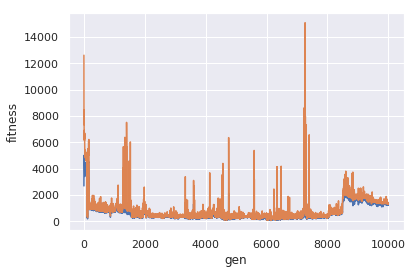

,eval,iter,id,a,fakeCoef,playing,oppId,nbOnOpp,curCoopNoCoef,otherCoop
0,0,0,46,5,1.068850,1,0,1,4.051440,0.000000
1,0,0,93,5,0.726857,1,0,2,2.880030,5.604650
2,0,0,2,5,1.186300,1,1,1,4.088780,0.000000
3,0,0,30,5,0.997499,1,1,2,2.880030,6.226150
4,0,0,60,5,0.903909,1,1,3,7.580930,16.630700
5,0,0,47,5,0.828617,1,1,4,8.256080,25.732000
6,0,0,89,5,1.144070,1,1,5,2.830150,11.152100
7,0,0,91,5,1.017530,1,0,3,7.597530,13.704200
8,0,0,69,5,1.101740,1,0,4,8.383080,23.446100
9,0,0,45,5,1.219790,1,0,5,2.827430,11.215100


In [3]:
dofolloworbit = True
for path in sorted(glob.glob("/home/pecoffet/remoterobo/logs/lions-nocost-2019-05-15-1759/lion/**/rep00/", recursive=True)):
    display(HTML(f'<h3>{path}</h3>'))
    fit = read_csvx(path + "fitnesslog.txt", delimiter="\t")
    fit = fit.groupby(['gen', 'ind'], as_index=False).sum()
    plt.figure()
    sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='median')
    sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='max')
    #sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='min')
    plt.show()
    logall = read_csvx(gethighest(glob.glob(path + 'logall*')), delimiter="\t")
    display(logall)
    logall.query('ind==0').pivot_table('')

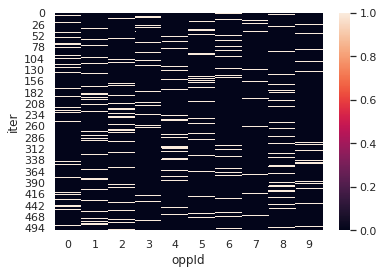

In [11]:
a = logall.query('id == 0 and eval == 0').pivot_table('id', 'iter', 'oppId', aggfunc='count')
a[np.isnan(a)] = 0
plt.figure(figsize=())
sns.heatmap(a)